# Machine Learning Project - Credit Card Lead Prediction

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (9, 5)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
dataset_url = 'https://www.kaggle.com/datasets/sajidhussain3/jobathon-may-2021-credit-card-lead-prediction' 

In [6]:
!pip install opendatasets --upgrade --quiet

In [7]:
import opendatasets as od
od.download(dataset_url)

Skipping, found downloaded files in "./jobathon-may-2021-credit-card-lead-prediction" (use force=True to force download)


In [8]:
data_dir = './jobathon-may-2021-credit-card-lead-prediction'

In [9]:
import os
os.listdir(data_dir)

['test.csv', 'train.csv', 'sample_submission.csv']

In [10]:
test_file_name = os.listdir(data_dir)[0]
train_file_name = os.listdir(data_dir)[1]

In [11]:
test_df = pd.read_csv(f"{data_dir}/{test_file_name}")
train_df = pd.read_csv(f"{data_dir}/{train_file_name}")

In [12]:
test_df.shape

(105312, 10)

In [13]:
train_df.shape

(245725, 11)

In [14]:
test_df.columns

Index(['ID', 'Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code',
       'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active'],
      dtype='object')

In [15]:
train_df.columns

Index(['ID', 'Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code',
       'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active',
       'Is_Lead'],
      dtype='object')

Since we only have the variable we are trying to predict ('Is_Lead') on the train_df we will only use the train dataset for the entire analysis.

In [16]:
df = train_df

In [17]:
df.dtypes

ID                     object
Gender                 object
Age                     int64
Region_Code            object
Occupation             object
Channel_Code           object
Vintage                 int64
Credit_Product         object
Avg_Account_Balance     int64
Is_Active              object
Is_Lead                 int64
dtype: object

In [18]:
df.Gender.value_counts()

Gender
Male      134197
Female    111528
Name: count, dtype: int64

In [19]:
df.Region_Code.value_counts()

Region_Code
RG268    35934
RG283    29416
RG254    26840
RG284    19320
RG277    12826
RG280    12775
RG269     7863
RG270     7720
RG261     7633
RG257     6101
RG251     5950
RG282     5829
RG274     5286
RG272     5252
RG281     5093
RG273     4497
RG252     4286
RG279     3976
RG263     3687
RG275     3245
RG260     3110
RG256     2847
RG264     2793
RG276     2764
RG259     2586
RG250     2496
RG255     2018
RG258     1951
RG253     1858
RG278     1822
RG262     1788
RG266     1578
RG265     1546
RG271     1542
RG267     1497
Name: count, dtype: int64

In [20]:
df.Occupation.value_counts()

Occupation
Self_Employed    100886
Salaried          71999
Other             70173
Entrepreneur       2667
Name: count, dtype: int64

In [21]:
df.Channel_Code.value_counts()

Channel_Code
X1    103718
X3     68712
X2     67726
X4      5569
Name: count, dtype: int64

In [22]:
df.Credit_Product.value_counts()

Credit_Product
No     144357
Yes     72043
Name: count, dtype: int64

In [23]:
df.Is_Active.value_counts()

Is_Active
No     150290
Yes     95435
Name: count, dtype: int64

Dropping the ID column since this will not be important as part of our model

In [24]:
df = df.drop(['ID'], axis=1)

In [25]:
df.columns = df.columns.str.lower()

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

In [26]:
categorical_columns

['gender',
 'region_code',
 'occupation',
 'channel_code',
 'credit_product',
 'is_active']

In [27]:
numeric_columns = ['age', 'vintage', 'avg_account_balance']

In [28]:
df.isnull().sum()

gender                     0
age                        0
region_code                0
occupation                 0
channel_code               0
vintage                    0
credit_product         29325
avg_account_balance        0
is_active                  0
is_lead                    0
dtype: int64

In [29]:
df.credit_product = df.credit_product.fillna('Unknown')

In [30]:
df.credit_product.value_counts()

credit_product
No         144357
Yes         72043
Unknown     29325
Name: count, dtype: int64

In [31]:
df.head()

,gender,age,region_code,occupation,channel_code,vintage,credit_product,avg_account_balance,is_active,is_lead
0,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,Female,30,RG282,Salaried,X1,33,No,886787,No,0


array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'vintage'}>],
       [<Axes: title={'center': 'avg_account_balance'}>, <Axes: >]],
      dtype=object)

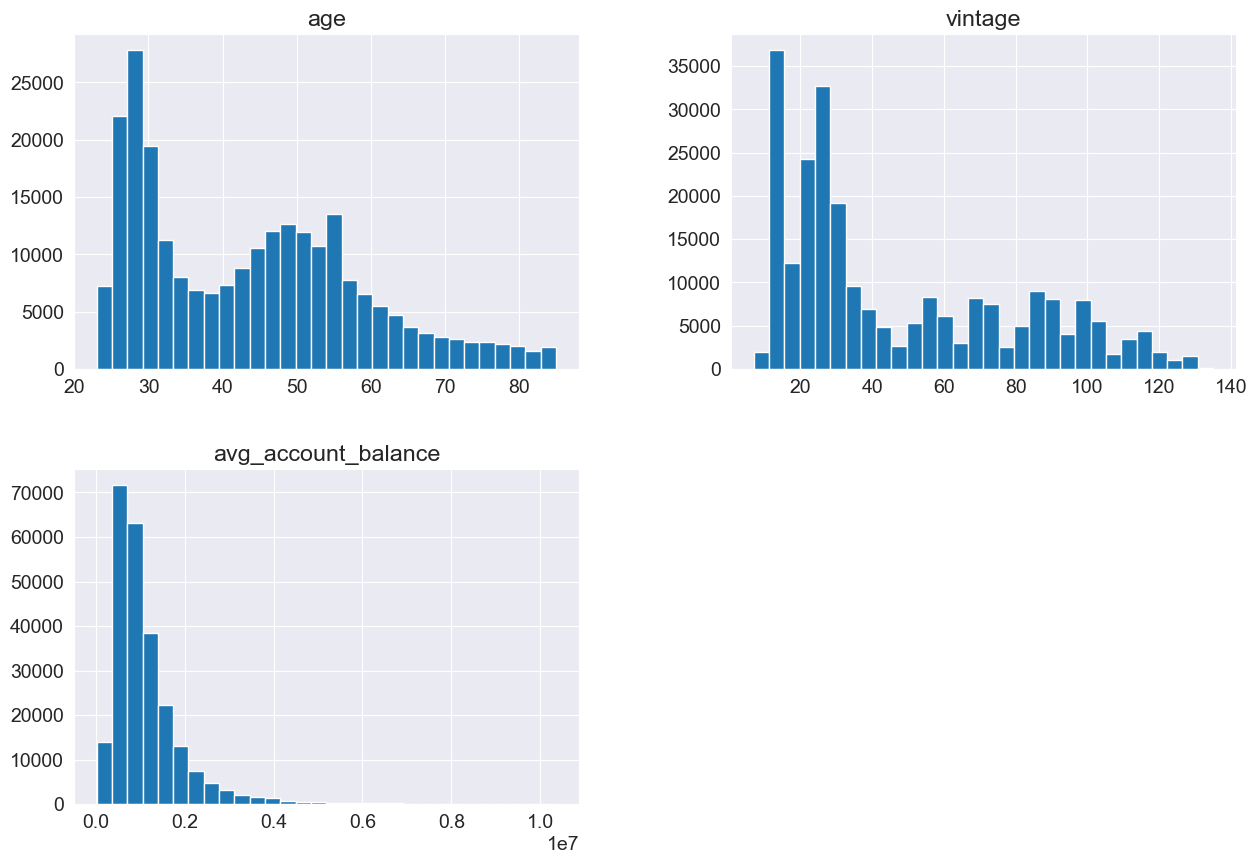

In [32]:
# Taking a look at the histograms for each of the numeric fields
df[numeric_columns].hist(bins=30, figsize=(15, 10))

We see that age, vintage and avg_account_balance do not even closely follow a normal distribution.  We will transform the data using the log to see if this might help.

In [33]:
age_logs = np.log1p(df.age)

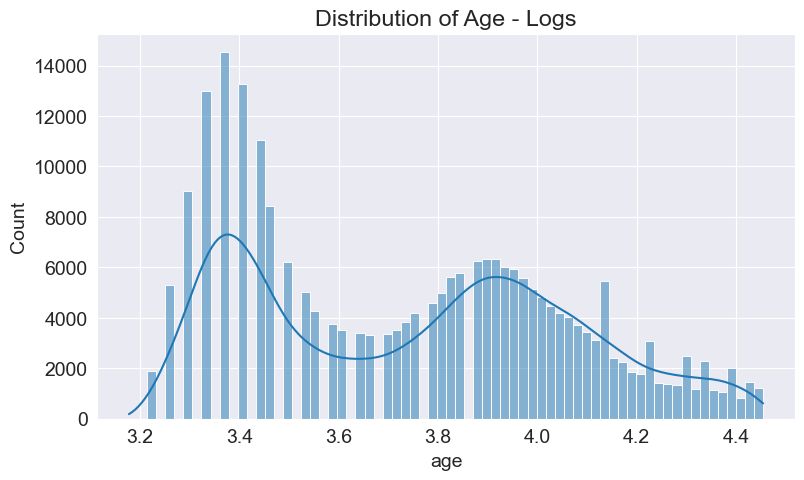

In [34]:
plt.title("Distribution of Age - Logs")
sns.histplot(x=age_logs, kde=True);

The log transformation does not help with the age distribution so we will leave age as is.

In [35]:
vintage_logs = np.log1p(df.vintage)

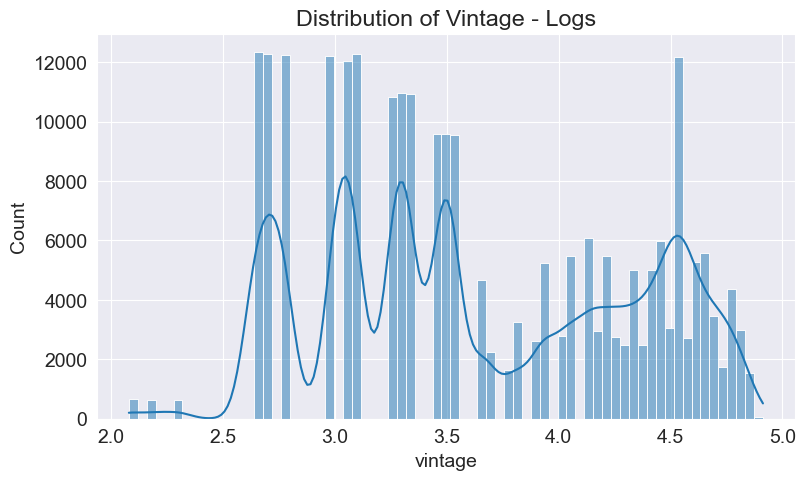

In [36]:
plt.title("Distribution of Vintage - Logs")
sns.histplot(x=vintage_logs, kde=True);

The log transformation does not help with the vintage distribution so we will leave vintage as is.

In [37]:
avg_bal_logs = np.log1p(df.avg_account_balance)

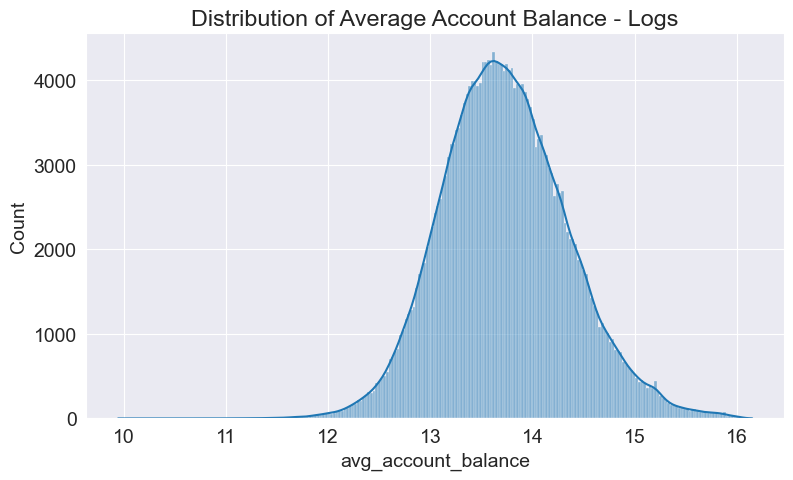

In [38]:
plt.title("Distribution of Average Account Balance - Logs")
sns.histplot(x=avg_bal_logs, kde=True);

We can see that we now have nicely distributed data for average account balance now that we have transformed the data to the log.

In [39]:
df.avg_account_balance = np.log1p(df.avg_account_balance)

### Review the pair-wise correlation coefficients for numeric predictors

In [40]:
corr_df = df[numeric_columns + ['is_lead']].corr('pearson')
corr_df

,age,vintage,avg_account_balance,is_lead
age,1.000000,0.631242,0.176838,0.230814
vintage,0.631242,1.000000,0.201592,0.279642
avg_account_balance,0.176838,0.201592,1.000000,0.073291
is_lead,0.230814,0.279642,0.073291,1.000000


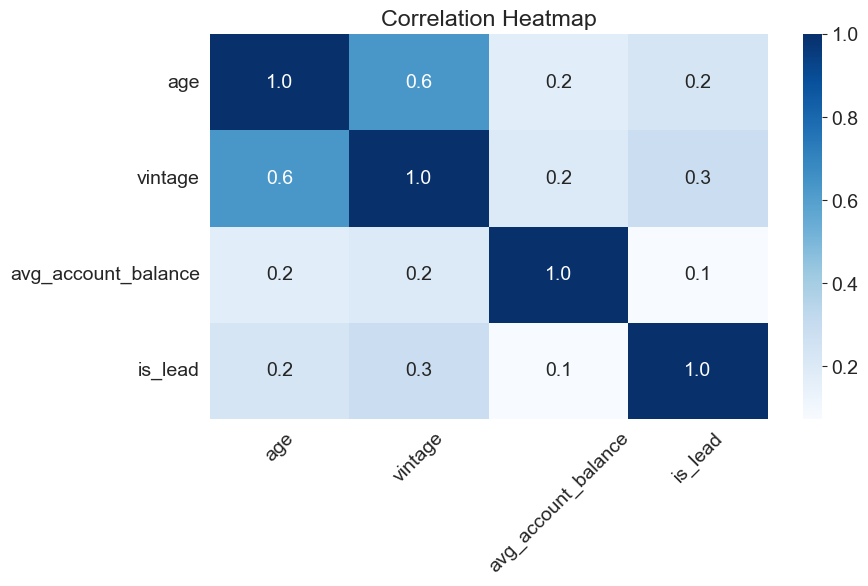

In [41]:
# Let's create a correlation heatmap to make it easier to see
plt.title("Correlation Heatmap")
plt.xticks(rotation=45)
sns.heatmap(corr_df, fmt=".1f", annot=True, cmap='Blues');

In [42]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.is_lead.values
y_val = df_val.is_lead.values
y_test = df_test.is_lead.values

del df_train['is_lead']
del df_val['is_lead']
del df_test['is_lead']

In [43]:
dv = DictVectorizer(sparse=False)

In [44]:
train_dict = df_train[categorical_columns + numeric_columns].to_dict(orient='records')

In [45]:
X_train = dv.fit_transform(train_dict)

## Logistic Regression Model

In [137]:
model = LogisticRegression(solver="liblinear")

In [138]:
model.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

### Evaluating the accuracy of our model
We will evaluate the accuracy of our model on the validation dataset using a threshold of 0.5.  If the model's predicted probability is greater than or equal to 0.5 then we predict that this individual would be a good lead, else we predict that the individual would not be a good lead.

In [139]:
val_dict = df_val[categorical_columns + numeric_columns].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
lead_decision = (y_pred >= 0.5)
(y_val == lead_decision).mean()

0.8516227490080375

Let's find a customer who is NOT predicted to be a good lead:

In [160]:
leads = y_pred < 0.5
list(leads).index(True)

0

In [161]:
y_pred[0]

0.02684809622933708

In [162]:
val_dict[0]

{'gender': 'Female',
 'region_code': 'RG269',
 'occupation': 'Other',
 'channel_code': 'X1',
 'credit_product': 'No',
 'is_active': 'No',
 'age': 36,
 'vintage': 27,
 'avg_account_balance': 12.727015912884449}

Let's find a customer who is predicted to be a good lead:

In [157]:
leads = y_pred >= 0.5
list(leads).index(True)

10

In [159]:
y_pred[10]

0.906837897723015

In [158]:
val_dict[10]

{'gender': 'Male',
 'region_code': 'RG269',
 'occupation': 'Self_Employed',
 'channel_code': 'X2',
 'credit_product': 'Unknown',
 'is_active': 'Yes',
 'age': 54,
 'vintage': 63,
 'avg_account_balance': 13.851664072068086}

### Perhaps there is a better threshold we can use?  
Let's check various thresholds:

In [49]:
len(y_val)

49145

In [50]:
from sklearn.metrics import accuracy_score

In [51]:
accuracy_score(y_val, y_pred >= 0.5)

0.8516227490080375

In [52]:
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.237
0.05 0.390
0.10 0.644
0.15 0.735
0.20 0.776
0.25 0.807
0.30 0.824
0.35 0.836
0.40 0.845
0.45 0.850
0.50 0.852
0.55 0.851
0.60 0.848
0.65 0.845
0.70 0.843
0.75 0.838
0.80 0.829
0.85 0.816
0.90 0.787
0.95 0.766
1.00 0.763


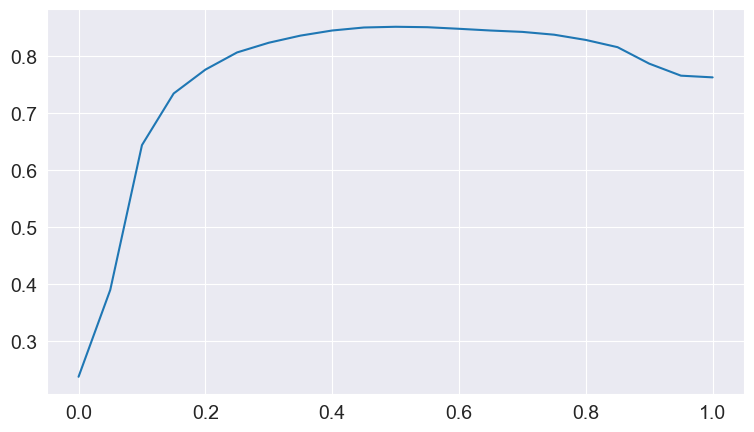

In [53]:
plt.plot(thresholds, scores)

The threshold that yields the highest accuracy (of 0.852) is 0.5.

### Confusion Table
Let's calculate the number of true positives, false positives, true negatives, and false negatives at a threshold of 0.5

In [54]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [55]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [56]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [57]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[36214,  1274],
       [ 6018,  5639]])

In [58]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.74, 0.03],
       [0.12, 0.11]])

In [59]:
# True Positive Rate (Sensitivity) - probability that an actual lead will be predicted to be a lead by the model
# In real world terms this means that our model at this threshold is not identifying over 50% of good leads!  
tpr = tp / (tp + fn)
tpr

0.48374367332933

In [60]:
# False Positive Rate - probability that the model will flag the individual as a lead when it really isn't
# In real world terms this might mean that in 3.4% of cases we would market to someone who is not interested in the credit card
fpr = fp / (fp + tn)
fpr

0.03398420827998293

Want to maximize true positive rate and minimize false positive rate

### ROC Curve

In [61]:
from sklearn.metrics import roc_curve

In [62]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

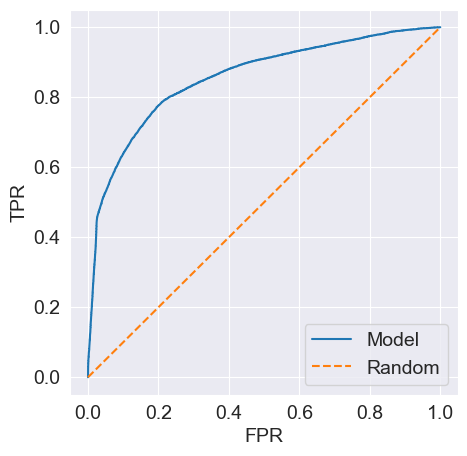

In [63]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

In [64]:
from sklearn.metrics import roc_auc_score

In [65]:
roc_auc_score(y_val, y_pred)

0.8560367386535125

AUC interpretation: Probability that a randomly selected positive individual (is_lead == 1) has a larger model score than a randomly selected negative individual (is_lead == 0).  An ideal model would have an AUC score closer to 1 but 0.856 isn't bad.  Let's see if other models can beat its performance.

## Decision Tree Model

In [66]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text

In [67]:
train_dicts = df_train.to_dict(orient='records')

In [68]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [69]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

### Evaluating the model

In [70]:
val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [71]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.7122129712030283

In [72]:
y_pred_train = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred_train)

0.9999999998731941

We have overfitting here (since the auc is 1 on the training dataset and only 0.711 on the validation dataset) so we need to control the number of levels

In [73]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

In [74]:
y_pred_train = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred_train)
print('train:', auc)

y_pred_val = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred_val)
print('val:', auc)

train: 0.8185672657411428
val: 0.81732541419631


### Parameter Tuning
* selecting `max_depth`
* selecting `min_samples_leaf`

In [75]:
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]

for depth in depths: 
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    print('%4s -> %.3f' % (depth, auc))

   1 -> 0.697
   2 -> 0.817
   3 -> 0.846
   4 -> 0.856
   5 -> 0.863
   6 -> 0.866
  10 -> 0.866
  15 -> 0.834
  20 -> 0.784
None -> 0.709


In [76]:
scores = []

for depth in [6, 8, 10, 12]:
    for s in [1, 5, 10, 15, 20, 500, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((depth, s, auc))

In [77]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

In [78]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
df_scores_pivot.round(3)

auc                     
max_depth            6      8      10     12
min_samples_leaf                            
1                 0.866  0.869  0.866  0.858
5                 0.867  0.871  0.869  0.864
10                0.867  0.871  0.870  0.866
15                0.867  0.871  0.870  0.867
20                0.867  0.871  0.870  0.867
100               0.867  0.871  0.870  0.868
200               0.867  0.870  0.870  0.870
500               0.864  0.868  0.868  0.868

<Axes: xlabel='None-max_depth', ylabel='min_samples_leaf'>

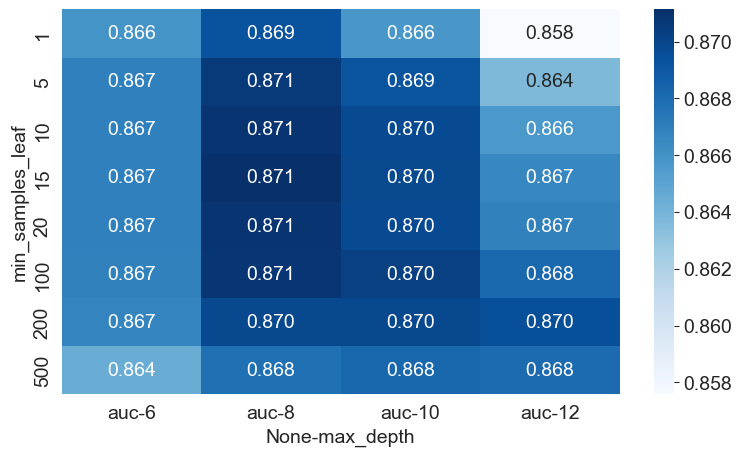

In [79]:
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f", cmap='Blues')

In [80]:
dt = DecisionTreeClassifier(max_depth=8, min_samples_leaf=100)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=8, min_samples_leaf=100)

In [81]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- credit_product=Unknown <= 0.50
|   |--- credit_product=Yes <= 0.50
|   |   |--- vintage <= 65.00
|   |   |   |--- channel_code=X1 <= 0.50
|   |   |   |   |--- occupation=Salaried <= 0.50
|   |   |   |   |   |--- vintage <= 29.00
|   |   |   |   |   |   |--- age <= 37.50
|   |   |   |   |   |   |   |--- vintage <= 20.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- vintage >  20.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- age >  37.50
|   |   |   |   |   |   |   |--- is_active=Yes <= 0.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- is_active=Yes >  0.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- vintage >  29.00
|   |   |   |   |   |   |--- vintage <= 55.50
|   |   |   |   |   |   |   |--- region_code=RG251 <= 0.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- region_code=RG251 >  0.50
|   |   |   |   |   |   |   |   |---

The decision tree is looking for customers who DON'T already have a credit product, a vintage less than or equal to 29 (months), a channel_code not equal to X1 (translates to a certain channel but we don't know the translation), occupation not equal to Salaried, age less than or equal to 37.5 (years), and so on...  

The decision tree model has an auc of 0.871 which is greater than our Logistic Regression Model's auc of 0.856

## Ensembles and Random Forest

In [82]:
from sklearn.ensemble import RandomForestClassifier

In [83]:
scores = []

for d in [5, 10, 15, 20]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, n, auc))

In [84]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

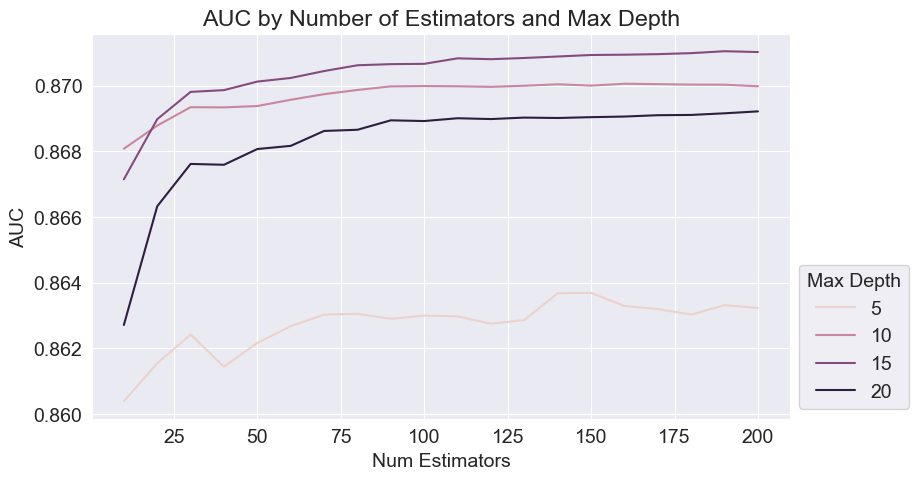

In [85]:
ax = sns.lineplot(x='n_estimators', y='auc', data=df_scores, hue = 'max_depth', errorbar=None);
ax.set(xlabel='Num Estimators', ylabel='AUC', title='AUC by Number of Estimators and Max Depth')
plt.legend(loc='lower left', bbox_to_anchor=(1, 0), title='Max Depth')
plt.show()

Max Depth of 15 is the best.

In [86]:
max_depth = 15

In [87]:
scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))

In [88]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

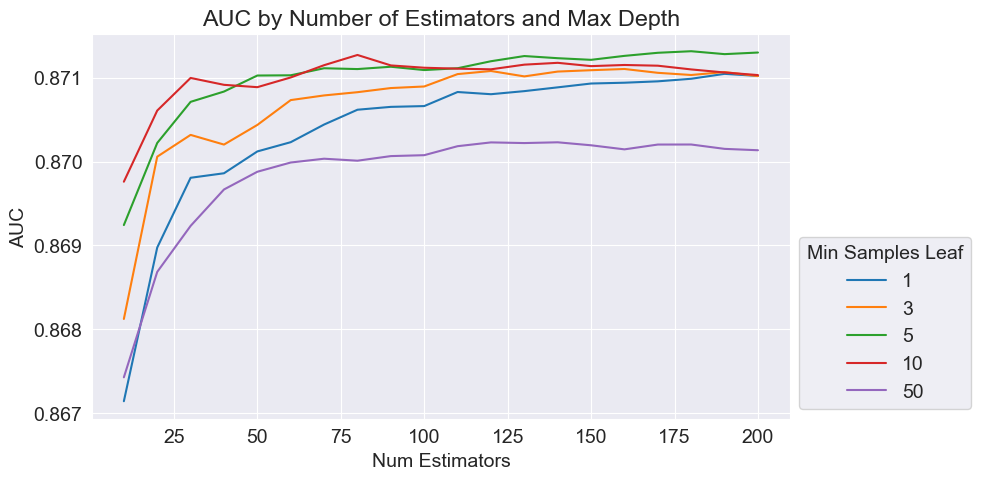

In [89]:
ax = sns.lineplot(x='n_estimators', y='auc', data=df_scores, hue = 'min_samples_leaf', errorbar=None, palette='tab10');
ax.set(xlabel='Num Estimators', ylabel='AUC', title='AUC by Number of Estimators and Max Depth')
plt.legend(loc='lower left', bbox_to_anchor=(1, 0), title='Min Samples Leaf')
plt.show()

We set the min samples leaf to 5 (green line in the graph above) because its AUC improves quickly and then it stays better than the others consistently without much up and down (unline the min samples leaf of 10, the red line).
We will set the number of estimators to 75 to keep the model as simple as possible.  We'd have to jump up to 130 to get a small increase in AUC.

In [90]:
min_samples_leaf = 5
n_estimators = 75

In [91]:
# Final random forest model
rf = RandomForestClassifier(n_estimators=n_estimators,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, min_samples_leaf=5, n_estimators=75,
                       random_state=1)

In [92]:
y_pred = rf.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
auc

0.8710881994834498

This has roughly the same AUC as our decision tree model.

## XG Boost Parameter Tuning

### Parameter Tuning

In [93]:
!pip install xgboost

In [94]:
import xgboost as xgb

In [95]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [96]:
features = dv.get_feature_names_out()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=tuple(features))
dval = xgb.DMatrix(X_val, label=y_val, feature_names=tuple(features))

In [97]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [98]:
scores = {}

In [99]:
%%capture output

# run this several times with eta values of 0.01, 0.05, 0.1, 0.3, and 1
xgb_params = {
    'eta': 1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [100]:
# run this several times (immediately after the prior line)
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=1'

In [101]:
list(scores.keys())

['eta=1']

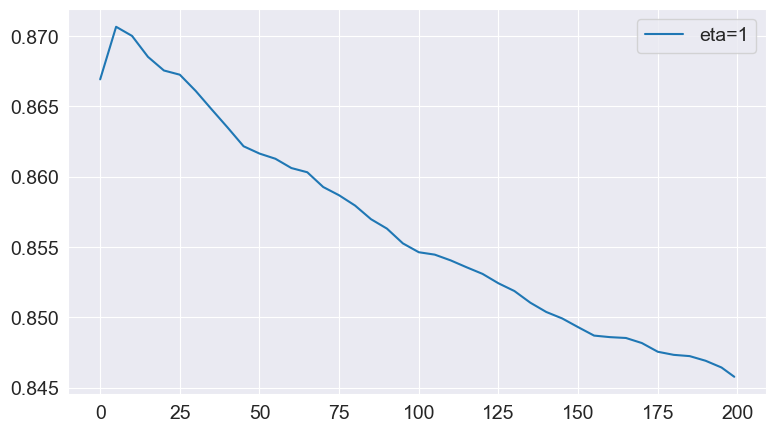

In [102]:
etas = list(scores.keys())

for eta in etas:
    df_score = scores[eta]
    plt.plot(df_score.num_iter, df_score.val_auc, label=eta)

plt.legend()

0.3 (red line) starts to decline too quickly, 0.1 (green line) increases quickly at first and then plateaus, we'll go with 0.1 for eta

In [103]:
eta = 0.1

Tuning the max_depth parameter, we'll start with 5, 10, 15, 20 (same values as what we tried in random forest)

In [104]:
scores = {}

In [105]:
%%capture output

# run this several times with max_depth values of 5, 10, 15, 20
xgb_params = {
    'eta': eta, 
    'max_depth': 20,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [106]:
# run this several times (immediately after the prior line)
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=20'

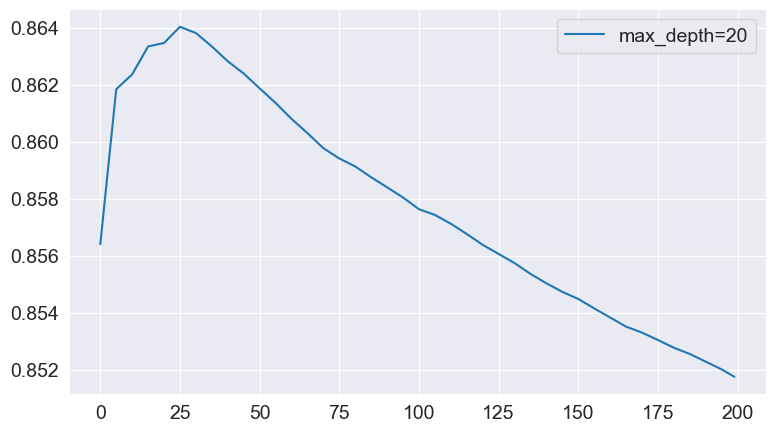

In [107]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=max_depth)

# plt.ylim(0.855, 0.9)
plt.legend()

max_depth of 5 is the best because it does not decline significantly unlike the others, it plateaus instead around 75

In [108]:
max_depth = 5

Final model:

In [109]:
xgb_params = {
    'eta': eta, 
    'max_depth': max_depth,
    'min_child_weight': 1, # using the default value here

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=75)

In [110]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8735008156200101

This is the best model with an AUC of 0.8735

We see that XGBoost is the best model (based on AUC) so now we will use the full training data set to train the model and then evaluate the final model on our test data set

In [111]:
df_full_train = df_full_train.reset_index(drop=True)

In [112]:
y_full_train = df_full_train.is_lead.values

In [113]:
del df_full_train['is_lead']

In [114]:
dicts_full_train = df_full_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [115]:
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train,
                    feature_names=tuple(dv.get_feature_names_out()))

dtest = xgb.DMatrix(X_test, feature_names=tuple(dv.get_feature_names_out()))

In [116]:
y_pred = model.predict(dtest)
y_pred

array([0.1474574 , 0.30946362, 0.3652135 , ..., 0.25652152, 0.44304964,
       0.1678588 ], dtype=float32)

In [117]:
roc_auc_score(y_test, y_pred)

0.8726627575982944

This is almost as good as the model that was trained on the smaller training dataset, we don't see overfitting here.

## Exporting the Model

### Save the Model

In [118]:
import pickle

In [119]:
output_file = 'lead_scoring_model.bin'

In [120]:
with open(output_file, 'wb') as f_out:
    pickle.dump((dv, model), f_out)

In [121]:
!ls -lh *.bin

-rw-r--r--@ 1 lizwi  staff   198K Mar 11 08:30 lead_scoring_model.bin


In [122]:
with open(output_file, 'wb') as f_out: 
    pickle.dump((dv, model), f_out)

### Load the Model

In [123]:
import pickle

In [124]:
input_file = 'lead_scoring_model.bin'

In [125]:
with open(input_file, 'rb') as f_in: 
    dv, model = pickle.load(f_in)

In [126]:
dv, model

(DictVectorizer(sparse=False), <xgboost.core.Booster at 0x2b012e0d0>)

Let's test on a random row from our training dataset

In [127]:
customer = {
    'gender': 'Male',
    'age': 75,
    'region_code': 'RG268',
    'occupation': 'Other',
    'channel_code': 'X2',
    'vintage': 62,
    'credit_product': 'Yes',
    'avg_account_balance': 13.664323648494173,
    'is_active': 'No'
}

In [128]:
X = dv.transform([customer])

In [129]:
X

array([[75.        , 13.66432365,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         1.        ,  1.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        , 62.        ]])

In [130]:
dtest = xgb.DMatrix(X, feature_names=tuple(dv.get_feature_names_out()))
y_pred = model.predict(dtest)
y_pred[0]

0.21424997

In [131]:
print('input:', customer)
print('output:', y_pred[0])

input: {'gender': 'Male', 'age': 75, 'region_code': 'RG268', 'occupation': 'Other', 'channel_code': 'X2', 'vintage': 62, 'credit_product': 'Yes', 'avg_account_balance': 13.664323648494173, 'is_active': 'No'}
output: 0.21424997


### Making Requests

In [163]:
import requests

In [164]:
url = 'http://localhost:9696/predict'

In [167]:
unlikely_customer = {'gender': 'Female',
     'region_code': 'RG269',
     'occupation': 'Other',
     'channel_code': 'X1',
     'credit_product': 'No',
     'is_active': 'No',
     'age': 36,
     'vintage': 27,
     'avg_account_balance': 12.727015912884449}

In [168]:
response = requests.post(url, json=unlikely_customer).json()
response

{'is_lead': False, 'lead_probability': 0.028}

In [169]:
likely_customer = {'gender': 'Male',
    'region_code': 'RG269',
    'occupation': 'Self_Employed',
    'channel_code': 'X2',
    'credit_product': 'Unknown',
    'is_active': 'Yes',
    'age': 54,
    'vintage': 63,
    'avg_account_balance': 13.851664072068086}

In [170]:
response = requests.post(url, json=likely_customer).json()
response

{'is_lead': True, 'lead_probability': 0.833}